# LIME explanations

In [1]:
import trustyai

trustyai.init(
    path=[
        "../dep/org/kie/kogito/explainability-core/2.0.0-SNAPSHOT/*",
        "../dep/org/slf4j/slf4j-api/1.7.30/slf4j-api-1.7.30.jar",
        "../dep/org/apache/commons/commons-lang3/3.12.0/commons-lang3-3.12.0.jar",
        "../dep/org/optaplanner/optaplanner-core/8.8.0.Final/optaplanner-core-8.8.0.Final.jar",
        "../dep/org/apache/commons/commons-math3/3.6.1/commons-math3-3.6.1.jar",
        "../dep/org/kie/kie-api/7.55.0.Final/kie-api-7.55.0.Final.jar",
        "../dep/io/micrometer/micrometer-core/1.6.6/micrometer-core-1.6.6.jar",
    ]
)

## Simple example

We start by defining our black-box model, typically represented by

$$
f(\mathbf{x}) = \mathbf{y}
$$

Where $\mathbf{x}=\{x_1, x_2, \dots,x_m\}$ and $\mathbf{y}=\{y_1, y_2, \dots,y_n\}$.

Our example toy model, in this case, takes an all-numerical input $\mathbf{x}$ and return a $\mathbf{y}$ of either `true` or `false` if the sum of the $\mathbf{x}$ components is within a threshold $\epsilon$ of a point $\mathbf{C}$, that is:

$$
f(\mathbf{x}, \epsilon, \mathbf{C})=\begin{cases}
\text{true},\qquad \text{if}\ \mathbf{C}-\epsilon<\sum_{i=1}^m x_i <\mathbf{C}+\epsilon \\
\text{false},\qquad \text{otherwise}
\end{cases}
$$

This model is provided in the `TestUtils` module. We instantiate with a $\mathbf{C}=500$ and $\epsilon=1.0$.

In [2]:
from trustyai.utils import TestUtils

center = 10.0
epsilon = 2.0

model = TestUtils.getSumThresholdModel(center, epsilon)

Next we need to define a **goal**.
If our model is $f(\mathbf{x'})=\mathbf{y'}$ we are then defining our $\mathbf{y'}$ and the counterfactual result will be the $\mathbf{x'}$ which satisfies $f(\mathbf{x'})=\mathbf{y'}$.

We will define our goal as `true`, that is, the sum is withing the vicinity of a (to be defined) point $\mathbf{C}$. The goal is a list of `Output` which take the following parameters

- The feature name
- The feature type
- The feature value (wrapped in `Value`)
- A confidence threshold, which we will leave at zero (no threshold)

In [3]:
from trustyai.model import Output, Type, Value
decision = "inside"
goal = [Output(decision, Type.BOOLEAN, Value(True), 0.0)]

We will now define our initial features, $\mathbf{x}$. Each feature can be instantiated by using `FeatureFactory` and in this case we want to use numerical features, so we'll use `FeatureFactory.newNumericalFeature`.

In [4]:
import random
from trustyai.model import FeatureFactory

features = [FeatureFactory.newNumericalFeature(f"x{i+1}", random.random()*10.0) for i in range(3)]

As we can see, the sum of of the features will not be within $\epsilon$ (1.0) of $\mathbf{C}$ (500.0). As such the model prediction will be `false`:

In [5]:
feature_sum = 0.0
for f in features:
    value = f.getValue().asNumber()
    print(f"Feature {f.getName()} has value {value}")
    feature_sum += value
print(f"\nFeatures sum is {feature_sum}")

Feature x1 has value 1.8272944653478607
Feature x2 has value 5.182372750848167
Feature x3 has value 4.847739719777713

Features sum is 11.85740693597374


We execute the model on the generated input and collect the output

In [6]:
from trustyai.model import PredictionInput, PredictionOutput

original = PredictionInput(features)
goals = model.predictAsync([original]).get()

We wrap these quantities in a `SimplePrediction`:

In [7]:
from trustyai.model import SimplePrediction

prediction = SimplePrediction(original, goals[0])

We can now instantiate the **explainer** itself.


In [8]:
from trustyai.explainers import LimeExplainer, LimeConfig

config = LimeConfig().withSamples(10)
explainer = LimeExplainer(config)

We generate the **explanation** as a _dict : decision --> saliency_.


In [9]:
exp = explainer.explain(prediction, model)

We inspect the saliency scores assigned by LIME to each feature

In [10]:
def print_saliency(exp, decision):
    for f in exp.get(decision).getPerFeatureImportance():
        print(f'{f.getFeature().getName()}: {f.getScore()}')

print_saliency(exp, decision)

x1: 0.009132315782870874
x2: 0.30607148824921715
x3: -0.09968280016406889


We turn the generated Saliency map into a Python dictionary, to be plotted as an horizontal chart (with *matplotlib*)

In [11]:
def s2dict(exp, decision):
    d = {}
    for f in exp.get(decision).getPerFeatureImportance():
        d[f.getFeature().getName()] = f.getScore()
    return d

s_dict = s2dict(exp, decision)

We generate the saliency graph with *matplotlib*

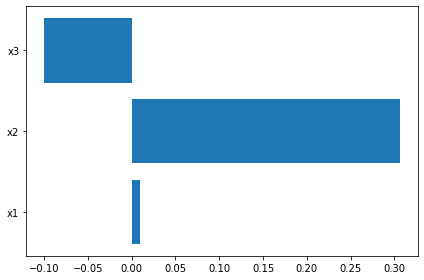

In [12]:
import matplotlib.pyplot as plt

def to_chart(s_dict):
    plt.barh(range(len(s_dict)), s_dict.values(), align='center')
    plt.yticks(range(len(s_dict)), list(s_dict.keys()))
    plt.tight_layout()

to_chart(s_dict)

## Using Python models



We will now show how to use a custom Python model with TrustyAI LIME implementation.

The model will be an XGBoost one trained with the `credit-bias` dataset.

For convenience, the model is pre-trained and serialised with `joblib` so that for this example we simply need to deserialised it.

In [13]:
import joblib

xg_model = joblib.load("model.joblib")
print(xg_model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.07, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=12, num_parallel_tree=1, random_state=27,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.9861206227457426,
              seed=27, subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)


This model has as a single **output** a boolean `PaidLoan`, which will predict whether a certain loan applicant will repay the loan in time or not. The model is slightly more complex than the previous examples, with **input** features:

|Input feature         | Type    | Note        |
|----------------------|---------|-------------|
|`NewCreditCustomer`   |boolean  ||
|`Amount`              |numerical||
|`Interest`            |numerical||
|`LoanDuration`        |numerical|In months|
|`Education`           |numerical|Level (1, 2, 3..)|
|`NrOfDependants`      |numerical|Integer|
|`EmploymentDurationCurrentEmployer`|numerical|Integer (years)|
|`IncomeFromPrincipalEmployer`|numerical||
|`IncomeFromPension`   |numerical||
|`IncomeFromFamilyAllowance`|numerical||
|`IncomeFromSocialWelfare`|numerical||
|`IncomeFromLeavePay`|numerical||
|`IncomeFromChildSupport`|numerical||
|`IncomeOther`|numerical||
|`ExistingLiabilities`|numerical|integer|
|`RefinanceLiabilities`|numerical|integer|
|`DebtToIncome`|numerical||
|`FreeCash`|numerical||
|`CreditScoreEeMini`|numerical|integer|
|`NoOfPreviousLoansBeforeLoan`|numerical|integer|
|`AmountOfPreviousLoansBeforeLoan`|numerical||
|`PreviousRepaymentsBeforeLoan`|numerical||
|`PreviousEarlyRepaymentsBefoleLoan`|numerical||
|`PreviousEarlyRepaymentsCountBeforeLoan`|numerical|integer|
|`Council_house`|boolean||
|`Homeless`|boolean||
|`Joint_ownership`|boolean||
|`Joint_tenant`|boolean||
|`Living_with_parents`|boolean||
|`Mortgage`|boolean||
|`Other`|boolean||
|`Owner`|boolean||
|`Owner_with_encumbrance`|boolean||
|`Tenant`|boolean||
|`Entrepreneur`|boolean||
|`Fully`|boolean||
|`Partially`|boolean||
|`Retiree`|boolean||
|`Self_employed`|boolean||

We will start by testing the model with an input we are quite sure (from the original data) that will be predicted as `false`:

In [14]:
x = [[False,2125.0,20.97,60,4.0,0.0,6.0,0.0,301.0,0.0,53.0,0.0,0.0,0.0,8,6,26.29,10.92,1000.0,1.0,500.0,590.95,0.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0]]

We can see that this application will be rejected with a probability of $\sim77\%$:

In [15]:
import numpy as np

print(xg_model.predict_proba(np.array(x)))
print(f"Paid loan is predicted as: {xg_model.predict(np.array(x))}")

[[0.7770493  0.22295067]]
Paid loan is predicted as: [False]


We will now prepare the XGBoost model to be used from the TrustyAI counterfactual engine.

To do so, we simply need to first create a prediction function which takes:

- A `java.util.List` of `PredictionInput` as inputs
- A `java.util.List` of `PredictionOutput` as outputs

If these two conditions are met, the actual inner working of this method can be anything (including calling a XGBoost Python model for prediction as in our case):

In [16]:
from typing import List
from trustyai.utils import toJList

def predict(inputs: List[PredictionInput]) -> List[PredictionOutput]:
    values = [feature.getValue().asNumber() for feature in inputs.get(0).getFeatures()]
    result = xg_model.predict_proba(np.array([values]))
    false_prob, true_prob = result[0]
    if false_prob > true_prob:
        prediction = (False, false_prob)
    else:
        prediction = (True, true_prob)
    output = Output("PaidLoan", Type.BOOLEAN, Value(prediction[0]), prediction[1])
    return toJList([PredictionOutput([output])])

Once the prediction method is created, we wrap in a `PredictionProvider` class.

This class takes care of all the JVM's asynchronous plumbing for us.

In [17]:
from trustyai.model import PredictionProvider

cb_model = PredictionProvider(predict)

We will now express the previous inputs (`x`) in terms of `Feature`s, so that we might use it for the counterfactual search:

In [18]:
def make_feature(name, value):
    if type(value) is bool:
        return FeatureFactory.newBooleanFeature(name, value)
    else:
        return FeatureFactory.newNumericalFeature(name, value)

features = [make_feature(p[0], p[1]) for p in [("NewCreditCustomer", False),
        ("Amount", 2125.0),
        ("Interest", 20.97),
        ("LoanDuration", 60.0),
        ("Education", 4.0),
        ("NrOfDependants", 0.0),
        ("EmploymentDurationCurrentEmployer", 6.0),
        ("IncomeFromPrincipalEmployer", 0.0),
        ("IncomeFromPension", 301.0),
        ("IncomeFromFamilyAllowance", 0.0),
        ("IncomeFromSocialWelfare", 53.0),
        ("IncomeFromLeavePay", 0.0),
        ("IncomeFromChildSupport", 0.0),
        ("IncomeOther", 0.0),
        ("ExistingLiabilities", 8.0),
        ("RefinanceLiabilities", 6.0),
        ("DebtToIncome", 26.29),
        ("FreeCash", 10.92),
        ("CreditScoreEeMini", 1000.0),
        ("NoOfPreviousLoansBeforeLoan", 1.0),
        ("AmountOfPreviousLoansBeforeLoan", 500.0),
        ("PreviousRepaymentsBeforeLoan", 590.95),
        ("PreviousEarlyRepaymentsBefoleLoan", 0.0),
        ("PreviousEarlyRepaymentsCountBeforeLoan", 0.0),
        ("Council_house", False),
        ("Homeless", False),
        ("Joint_ownership", False),
        ("Joint_tenant", False),
        ("Living_with_parents", False),
        ("Mortgage", False),
        ("Other", False),
        ("Owner", False),
        ("Owner_with_encumbrance", True),
        ("Tenant", True),
        ("Entrepreneur", False),
        ("Fully", False),
        ("Partially", False),
        ("Retiree", True),
        ("Self_employed", False)]]

We can confirm now, with the newly created `PredictionProvider` model that this input will lead to a `false` `PaidLoan` prediction:

In [19]:
from trustyai.utils import toJList
prediction_input = PredictionInput(features)
prediction_inputs = toJList([prediction_input])
prediction_output = model.predictAsync(prediction_inputs).get()[0]
prediction_output.getOutputs()[0].toString()

'Output{value=false, type=boolean, score=-4705.13, name='inside'}'

We generate a prediction to be passed to the LIME explainer

In [20]:
prediction = SimplePrediction(prediction_input, prediction_output)

We execute the LIME explainer on the XGBoost model and prediction

In [21]:
cb_config = LimeConfig()
cb_explainer = LimeExplainer(cb_config)
cb_exp = cb_explainer.explain(prediction, cb_model)

We output the top 2 most important features for the prediction outcome

In [22]:
for f in cb_exp['inside'].getTopFeatures(2):
    print(f)

FeatureImportance{feature=Feature{name='NewCreditCustomer', type=boolean, value=false}, score=0.9998912987399108, confidence= +/-0.0}
FeatureImportance{feature=Feature{name='Amount', type=number, value=2125.0}, score=0.9998912987399108, confidence= +/-0.0}
